a=0.020 pm 0.001, b=0.107 pm 0.004, chi-sqr=0.005


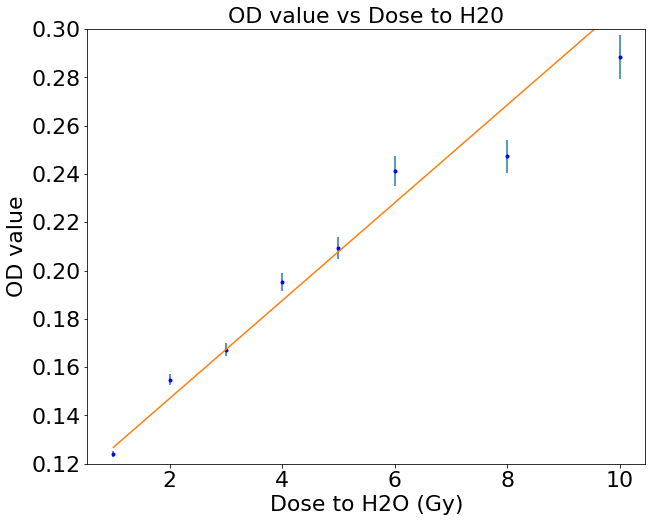

pv_min=1.000, pv_max=210.884, b=0.339, d_0=19.900 and chi-sqr=0.289


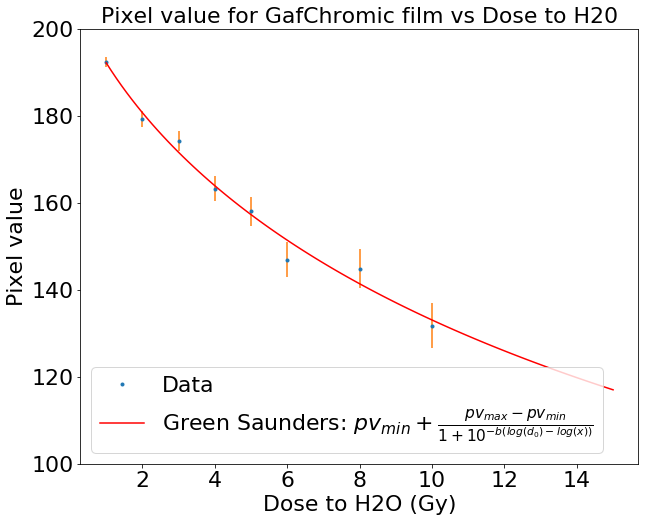

a=256.000, b=-2.303, chi-sqr=0


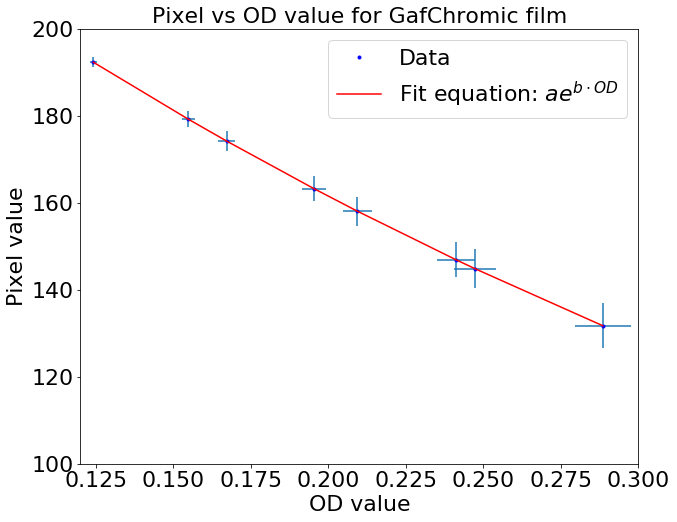

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import chisquare
from scipy.optimize import curve_fit
from scipy import stats
from scipy.optimize import least_squares
import cv2
import tifffile as tiff
import os

x = np.linspace(1,15,100)
filename = 'Calib_10days/Calibration_10days_'
params = {'legend.fontsize': '22',
          'figure.figsize': (10, 8),
         'axes.labelsize': '22',
         'axes.titlesize':'22',
         'xtick.labelsize':'22',
         'ytick.labelsize':'22'}
plt.rcParams.update(params)
path, dirs, files = next(os.walk('Calib_10days/'))
file_count = np.arange(0,len(files),1)
def pv(x,pv_min,pv_max,b,d_0): return (pv_min + (pv_max-pv_min))/((1+10**(-1*b*(np.log(d_0)-np.log(x))))) 
def image_ret(file_num): return tiff.imread(filename+str(file_num)+'.tiff')
def pixel_val(image):
    roi = ([100,400],[50,350])
    x = image[:,:,0].mean(axis=0)[roi[0][0]:roi[0][1]]
    y = image[:,:,0].mean(axis=1)[roi[1][0]:roi[1][1]]
    max_x = np.argmax(np.gradient(x))
    min_x = np.argmin(np.gradient(x))
    max_y = np.argmax(np.gradient(y))
    min_y = np.argmin(np.gradient(y))
    bckgr = image[:,:,0][:min_x,max_x:][:min_y,max_y:]
    inner = image[:,:,0][min_x:max_x][min_y:max_y]
    in_avg = np.mean(inner)
    in_std = np.std(inner)/np.sqrt(len(inner))
    bckgr_avg = np.mean(bckgr)
    bckgr_std = np.std(bckgr)
    return ([in_avg,in_std,bckgr_avg,bckgr_std])

a = image_ret(10)[:,:,0]
numbers = ([1,2,3,4,5,6,8,10])
doses = np.array([numbers, *[*zip(*[pixel_val(image_ret(i)) for i in numbers])]])
OD = np.log10(np.array(256)/np.array(doses[1]))
plt.plot(doses[0],OD,'b.',label=r'OD equation: $OD = log_{10}\left(\frac{I_{0}}{I}\right)$')
def poly(x,a,b):return a*x+b
popt, pcov = scipy.optimize.curve_fit(poly,doses[0],OD,p0=[0.026,0.12],sigma=np.log10(256)*(-np.log(10)*doses[2])/(doses[1]*(np.log(doses[1]))**2))
perr = np.sqrt(np.diag(pcov))
chi_fit = chisquare(OD,[poly(i,*popt) for i in doses[0]])[0]
slope, intercept, r_value, p_value, std_err = stats.linregress(doses[0],OD)
plt.errorbar(x=doses[0],y=OD,xerr=0.01, yerr=np.log10(256)*(-np.log(10)*doses[2])/(doses[1]*(np.log(doses[1]))**2),ls='None')
plt.plot(doses[0],[poly(i,*popt) for i in doses[0]],label=r'Fit equation = $ax+b$')
print('a={:.3f} pm {:.3f}, b={:.3f} pm {:.3f}, chi-sqr={:.3f}'.format(popt[0],perr[0],popt[1],perr[1],chi_fit))
plt.title("OD value vs Dose to H20")
plt.xlabel("Dose to H2O (Gy)")
plt.ylabel("OD value")
plt.ylim(0.12,0.3)
plt.show()


popt, pcov = scipy.optimize.curve_fit(pv,doses[0],doses[1],p0=[1,120,1,3.5],sigma=doses[2])
chi_fit = chisquare(doses[1],[pv(i,*popt) for i in doses[0]])[0]
print('pv_min={:.3f}, pv_max={:.3f}, b={:.3f}, d_0={:.3f} and chi-sqr={:.3f}'.format(popt[0],popt[1],popt[2],popt[3],chi_fit))
plt.plot(doses[0],doses[1],'.',label='Data')
plt.errorbar(x=doses[0],y=doses[1],xerr=0.01, yerr=doses[2],ls='None')
plt.title("Pixel value for GafChromic film vs Dose to H20")
plt.xlabel("Dose to H2O (Gy)")
plt.ylabel("Pixel value")
plt.ylim(100,200)
plt.plot(x,pv(x,*popt),'r-',label=r'Green Saunders: $pv_{min}+\frac{pv_{max}-pv_{min}}{1+10^{-b(log(d_{0})-log(x))}}$')
plt.legend()
plt.show()

plt.plot(OD,doses[1],'b.',label='Data')
def fit_OD_pv(OD,a,b):return a*np.exp(b*OD)
popt, pcov = scipy.optimize.curve_fit(fit_OD_pv,OD,doses[1],p0=[1,1],sigma=doses[2])
chi_fit = chisquare(doses[1],[fit_OD_pv(i,*popt) for i in OD])[0]
print('a={:.3f}, b={:.3f}, chi-sqr={:.3g}'.format(popt[0],popt[1],chi_fit))
plt.plot(OD,fit_OD_pv(OD,*popt),'r-',label=r'Fit equation: $ae^{b\cdot OD}$')
plt.errorbar(x=OD,y=doses[1],yerr=doses[2],xerr=np.log10(256)*(-np.log(10)*doses[2])/(doses[1]*(np.log(doses[1]))**2),ls='None')
plt.title("Pixel vs OD value for GafChromic film")
plt.xlabel("OD value")
plt.xlim(0.12,0.3)
plt.ylim(100,200)
plt.ylabel("Pixel value")
plt.legend()
plt.show()

